# Evaluate Agents

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from stable_baselines3 import DQN, DDPG

from alphaQ.utils import download_ticker_data, train_test_split, plot_episodes, sharpe, save_to_s3, load_from_s3
from alphaQ.env import PortfolioEnv
from alphaQ.agent.features import FeatureExtractor
from alphaQ.agent.callbacks import EvalCallback
from alphaQ.agent.utils import AgentStrategy, load_model, display_attributes
from alphaQ.eval import evalu8, evaluate_baselines

import config
from config import TICKERS, MODELS, MODEL_PARAMS

warnings.filterwarnings('ignore')

rcParams = {
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.figsize': (18, 9),
    'legend.fontsize': 13,
    'axes.labelsize': 14
}
plt.rcParams.update(rcParams)

In [2]:
# Load ticker and market data, split into train, validation and test sets
esg_key = 'tradeGPT/prices/esg.pkl'
market_key = 'tradeGPT/prices/market.pkl'  # SPY

tickers = ["MSFT", "NVDA", "GOOGL", "LLY"]  # MSCI USA ESG Leaders Index (USD)

if False:
    data = download_ticker_data(tickers, start=config.START, end=config.END, columns=['Open', 'High', 'Low', 'Close']).dropna()
    save_to_s3(data, esg_key)
    market = download_ticker_data('SPY', start=config.START, end=config.END, columns=['Adj Close']).loc[data.index]
    save_to_s3(market, market_key)
else:
    data = load_from_s3(esg_key)
    market = load_from_s3(market_key)

train, val, test = train_test_split(data, train_years=12)
market_train, market_val, market_test = train_test_split(market, train_years=12)

In [3]:
agents = []
model = 'dqn'  # 'ddpg'  

dqn
EPISODE: 1 Steps: 703
Training episode reward: 0.7346066869621203
Total wealth: 1.7494


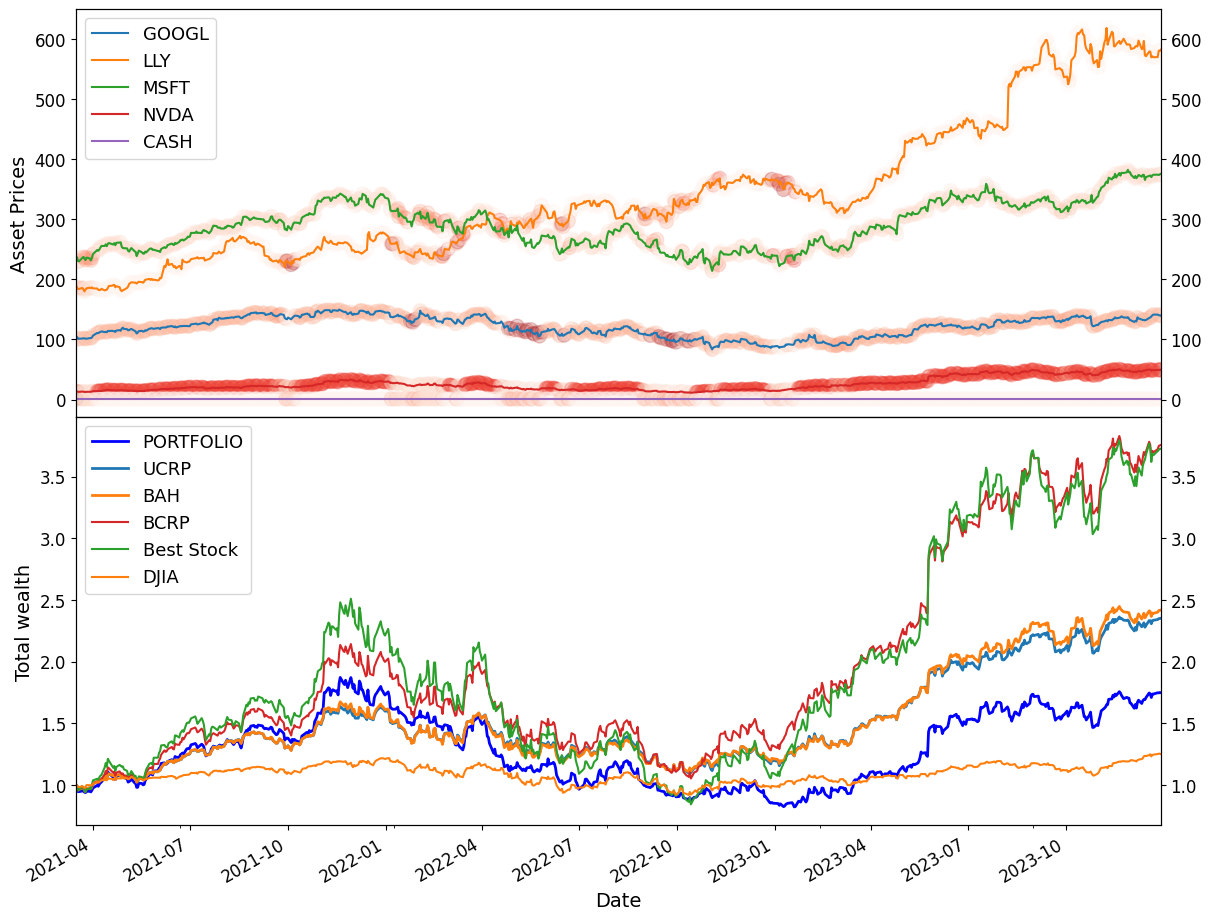

learning_rate: 2e-05
gamma: 0.5
batch_size: 64
buffer_size: 10000
polyak_update: 0.005
epsilon_initial: 0.8 	epislon_final: 0.01 	epislon_fraction: 0.4
feature_extractor:
Sequential(
  (0): Conv2d(4, 4, kernel_size=(1, 8), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(1, 16), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(1, 28), stride=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
)
net_arch: [256, 128, 64]



In [4]:
agent_strategies = []
agents.append((model, MODELS[model].load("models/esg_dqn_low_lr/best_model.zip")))

# for all loaded agents
for model, agent in agents:
    
    # determing action space type
    action_space_type = config.ACTION_SPACE[model]

    # set up test environment
    test_env = PortfolioEnv(
        tickers=TICKERS,
        prices=test, 
        market_prices=market_test,
        window_length=config.WINDOW_LENGTH,
        trading_cost=config.COMMISSION_RATE,
        action_space_type=action_space_type,
#         render_mode='test'
    )
    
    print(model)
    # evaluate agent on test environment and plot results
    evalu8(agent, test_env)
    
    # display agent attributes
    display_attributes(agent, test_env.observation_space)    

    # wrap agent weights in universal portfolios interface for comparison
    strategy = AgentStrategy(test_env.record.actions, name=model.upper())
    agent_strategies.append(strategy)

In [6]:
results, metrics = evaluate_baselines(test, custom_strategies=agent_strategies, market_data={'DJIA': market_test}, attributes=None)
metrics

DQN.BAH.CRP.BCRP.DJIA.

,total_wealth,cumulative_return,annualised_return,sharpe,max_drawdown,max_drawdown_period,ulcer_index,profit_factor,winning_pct,beta,alpha,information_ratio,annualised_volatility,annual_turnover
DQN,1.749448,74.944769,22.205629,0.73859,56.00057,528.127117,0.869122,1.10016,50.852273,1.145468,-0.139791,-0.513057,0.356845,57.564388
BAH,2.419446,141.944597,37.271341,1.274921,33.758677,364.397727,2.330136,1.204961,51.846591,1.005652,0.001615,0.094863,0.279025,0.0
CRP,2.35246,135.245975,35.896372,1.253614,32.854743,335.445579,2.459124,1.201869,52.414773,0.999808,-0.007535,-5.035654,0.274827,2.671438
BCRP,3.757088,275.708828,60.735116,1.3579,50.820821,346.427428,2.640318,1.214781,52.698864,1.377478,0.073472,1.079122,0.411313,2.535049
DJIA,1.251943,25.194254,8.389824,0.543603,24.496382,487.19477,0.890424,1.080256,52.136752,1.000011,-0.000897,-0.598787,0.177039,0.0
